# Reinforcement Learning: An Introduction; Richard S. Sutton and Andrew G. Barto

## Temporal Difference Learning


### TD learning combines both the dynamic programing as well as monte carlo method
### Like MC, TD can learn from raw experiance; does not need a model
### Like DP, TD can look one step ahead rather waiting for a complete episode

### The value function estimation in TD is calculated by: $V(S_t)^{k+1} = V(S_t)^k + \alpha [G_t - V(S_t)^k]$
$V(S_t)^{k+1} = V(S_t)^k + \alpha [R_{t+1} + \gamma V^k(S_{t+1}) - V(S_t)^k]$
### Bootstrapping: As the value function update in TD uses a part of the existing value function; it is called a bootstrapping method

### TD(0) Algorithm:
### Input: The policy to be evaluated: $\pi$
### Initialise: $V(s) = 0$ for $s \in S^+$
### For each episode:
### &emsp;&emsp; Initialise $S$
### &emsp;&emsp; Repeat for each step in the episode:
### &emsp;&emsp;&emsp;&emsp; $A = $ action given by $\pi$ for $S$
### &emsp;&emsp;&emsp;&emsp; Take action $A$, observe reward $R$ and next state $S'$ 
### &emsp;&emsp;&emsp;&emsp; $V(s) ← V(s) + \alpha [R + \gamma V(s') - V(s)]$
### &emsp;&emsp;&emsp;&emsp; Update state $s ← s'$
### &emsp;&emsp; Until the episode terminates



In [1]:
## Mout your google drive
from google.colab import drive
## mount location
drive.mount('/content/drive')

Mounted at /content/drive


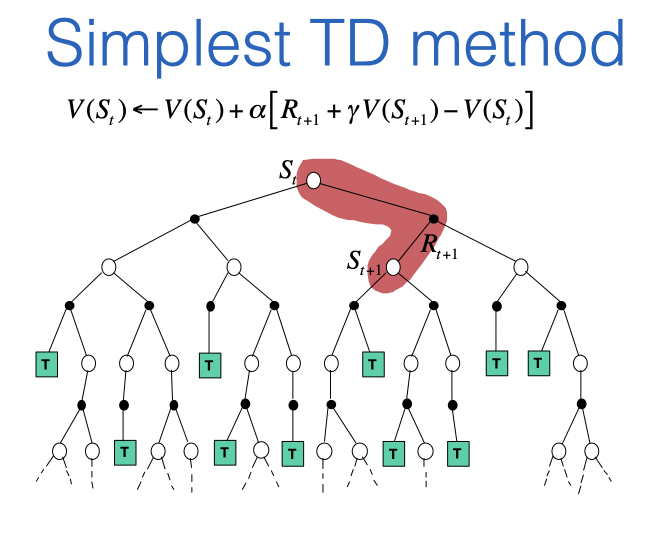

In [2]:
## https://web.stanford.edu/class/cme241/lecture_slides/rich_sutton_slides/11-12-TD.pdf
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/drive/MyDrive/rl/td.png", cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2), cv2.INTER_CUBIC)
cv2_imshow(img)

## On-Policy TD with SARSA (State Action Reward State Action)


### SARSA is an on-policy RL algorithm; which means that the agent improves its actions based on the same policy

### In contrast to TD(0) where the agent learns using the transitions between state values, SARSA learns by using the state-action values Q(S,A)

### Algorithm:
### Initialize $Q(s, a), ∀s ∈ S, a ∈ A(s)$, arbitrarily, and $Q(terminal-state, ·) = 0$
### Repeat (for each episode):
### &emsp;&emsp; Initialize $S$
### &emsp;&emsp; Choose A from S using policy derived from Q (e.g., ε-greedy)
### &emsp;&emsp; Repeat (for each step of episode):
### &emsp;&emsp;&emsp;&emsp; Take action A, observe R, S′
### &emsp;&emsp;&emsp;&emsp; Choose $A′$ from $S′$ using policy derived from $Q$ (e.g., ε-greedy)
### &emsp;&emsp;&emsp;&emsp; $Q(S, A) ← Q(S, A) + α[R + γQ(S′, A′) − Q(S, A)]$
### &emsp;&emsp;&emsp;&emsp; $S ← S′; A ← A′$
### &emsp;&emsp; until S is terminal


In [248]:
## https://github.com/shirsho-12/RL/tree/main/TD
import torch
from tqdm import tqdm
from collections import defaultdict
import gym

In [249]:
def gen_eps_greedy_policy(num_actions, epsilon):
    
    # Epsilon Greedy exploratory policy 
    def policy_function(state, Q):
      probs = torch.ones(num_actions) * epsilon / num_actions
      best_action = torch.argmax(Q[state]).item()
      probs[best_action] += 1 - epsilon
      action = torch.multinomial(probs, 1).item()
      
      return action
    return policy_function

In [250]:
def sarsa(env, gamma, num_episodes, alpha, eps_policy):
    episode_length = [0] * num_episodes
    total_reward_episode = [0] * num_episodes
    num_actions = env.action_space.n

    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        action = eps_policy(state, Q)
        while not is_done:
            next_state, reward, is_done, info = env.step(action)
            next_action = eps_policy(next_state, Q)
            del_td = reward + gamma * Q[next_state][next_action] - Q[state][action]
            Q[state][action] += alpha * del_td
            # For plotting
            episode_length[episode] += 1
            total_reward_episode[episode] += reward
            state = next_state
            action = next_action
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy, {"rewards": total_reward_episode, "length": episode_length}

In [251]:
env = gym.make("FrozenLake-v0")
num_actions, num_states = env.action_space.n, env.observation_space.n
print(num_actions, num_states)

num_episodes = 1000
gamma = 1.0
alpha = 0.1
epsilon = 0.7     # Grid Search parameters
eps_policy = gen_eps_greedy_policy(env.action_space.n, epsilon)
optimal_Q, optimal_policy, info = sarsa(env, gamma, num_episodes, alpha, eps_policy)

4 16


100%|██████████| 1000/1000 [00:01<00:00, 504.16it/s]


In [252]:
print(optimal_policy)
def test_policy(env, policy, trials):
  success = 0
  for _ in range(trials):
    env.reset()
    finished = False
    while not finished:
        _new_s, _reward, finished, _info =  env.step(policy[env.env.s])
        #env.render()
        if _reward == 1:
          success += 1
        if finished: break
  print(success)

{0: 3, 4: 0, 8: 1, 9: 2, 5: 0, 12: 0, 1: 3, 2: 2, 6: 1, 7: 0, 13: 2, 3: 1, 10: 1, 14: 1, 11: 0, 15: 0}


In [253]:
test_policy(env, optimal_policy, 1000)

82


## Q-Learning

### Q learning is an off-policy TD algorithm that directly approximates the optimal policy despite the policy being followed

### In SARSA the update rule of the Q function is:
### $Q(S_t, A_t) ← Q(S_t, A_t) + α[R_{t+1} + γQ(S_{t+1}, A_{t+1}) − Q(S_t, A_t)]$
### where the agen uses the current "Behavior" policy to update the Q function; on-policy update
### However in Q-Learning the update policy is:
### $Q(S_t, A_t) ← Q(S_t, A_t) + α[R_{t+1} + γ max Q(S_{t+1}, a) − Q(S_t, A_t)$ where the optimal (sub) "Target" policy $max Q(St+1, a)$ is used to update the Q function;

### Algorithm:
Initialize $Q(s, a), ∀s ∈ S, a ∈ A(s)$, arbitrarily, and $Q(terminal-state, ·) = 0$
### Repeat (for each episode):
### &emsp;&emsp; Initialize S
### &emsp;&emsp; Repeat (for each step of episode):
### &emsp;&emsp;&emsp;&emsp; Choose A from S using policy derived from Q (e.g., ε-greedy)
### &emsp;&emsp;&emsp;&emsp; Take action A, observe R, S′
### &emsp;&emsp;&emsp;&emsp; $Q(S, A) ← Q(S, A) + α[R + γ maxa Q(S′, a) − Q(S, A)]$
### &emsp;&emsp;&emsp;&emsp; $S ← S′$
### &emsp;&emsp; until S is terminal

In [254]:
def q_learning(env, behaviour_policy, gamma, num_episodes, alpha):
    episode_length = [0] * num_episodes
    total_reward_episode = [0] * num_episodes
    num_actions = env.action_space.n

    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        # if (episode + 1) % 400 == 0:
        #     alpha /= 2
        state = env.reset()
        is_done = False
        while not is_done:
            action = behaviour_policy(state, Q)
            next_state, reward, is_done, info = env.step(action)
            # Time step update
            del_td = reward + gamma * torch.max(Q[next_state]) - Q[state][action]   
            Q[state][action] += alpha * del_td
            state = next_state
            total_reward_episode[episode] += reward
            episode_length[episode] += 1
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy, {"rewards": total_reward_episode, "length": episode_length}

In [255]:
env = gym.make("FrozenLake-v0")
num_actions, num_states = env.action_space.n, env.observation_space.n
print(num_actions, num_states)

num_episodes = 1000 
gamma = 1.0
alpha = 0.4
epsilon = 0.7
behaviour_policy = gen_eps_greedy_policy(env.action_space.n, epsilon)

optimal_Q, optimal_policy, info = q_learning(env, behaviour_policy, gamma, num_episodes, alpha)

4 16


100%|██████████| 1000/1000 [00:02<00:00, 472.96it/s]


In [256]:
print(optimal_policy)
def test_policy(env, policy, trials):
  success = 0
  for _ in range(trials):
    env.reset()
    finished = False
    while not finished:
        _new_s, _reward, finished, _info =  env.step(policy[env.env.s])
        #env.render()
        if _reward == 1:
          success += 1
        if finished: break
  print(success)

{0: 0, 1: 3, 2: 3, 3: 3, 6: 0, 10: 0, 14: 1, 7: 0, 5: 0, 4: 0, 8: 3, 12: 0, 9: 1, 13: 2, 11: 0, 15: 0}


In [257]:
test_policy(env, optimal_policy, 1000)

746
